# Steps of a Machine Learning Workflow

## 1) Define business goal / question of interest / research question

- Predict the amount of bike rentals at a specific time
- This might be helpful in order to schedule bike repairs

## 2) Get data

In [38]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [39]:
df = pd.read_csv('train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [40]:
# Define Variable of interest
y = df['count']
X = df.drop(['count', 'casual', 'registered'], axis=1)

In [41]:
y.shape, X.shape

((10886,), (10886, 9))

## 3) Train-test-split

The idea behind splitting the data into a training and a test set is that in the end we have part of the data (the test set) which the model has never seen. This will help us to ultimately decide whether our model is able to generalize and whether it reaches a quality that we are happy with/helps us in achieving our goal.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [43]:
X_train.shape, X_test.shape

((8164, 9), (2722, 9))

The test set is now not touched until we are done with building the model. It should only be used once.

## 4) EDA

Disclaimer: This is not a full exploratory data analysis but just very few examples.

In [44]:
# Checking for null values
X_train.isna().any()

datetime      False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
dtype: bool

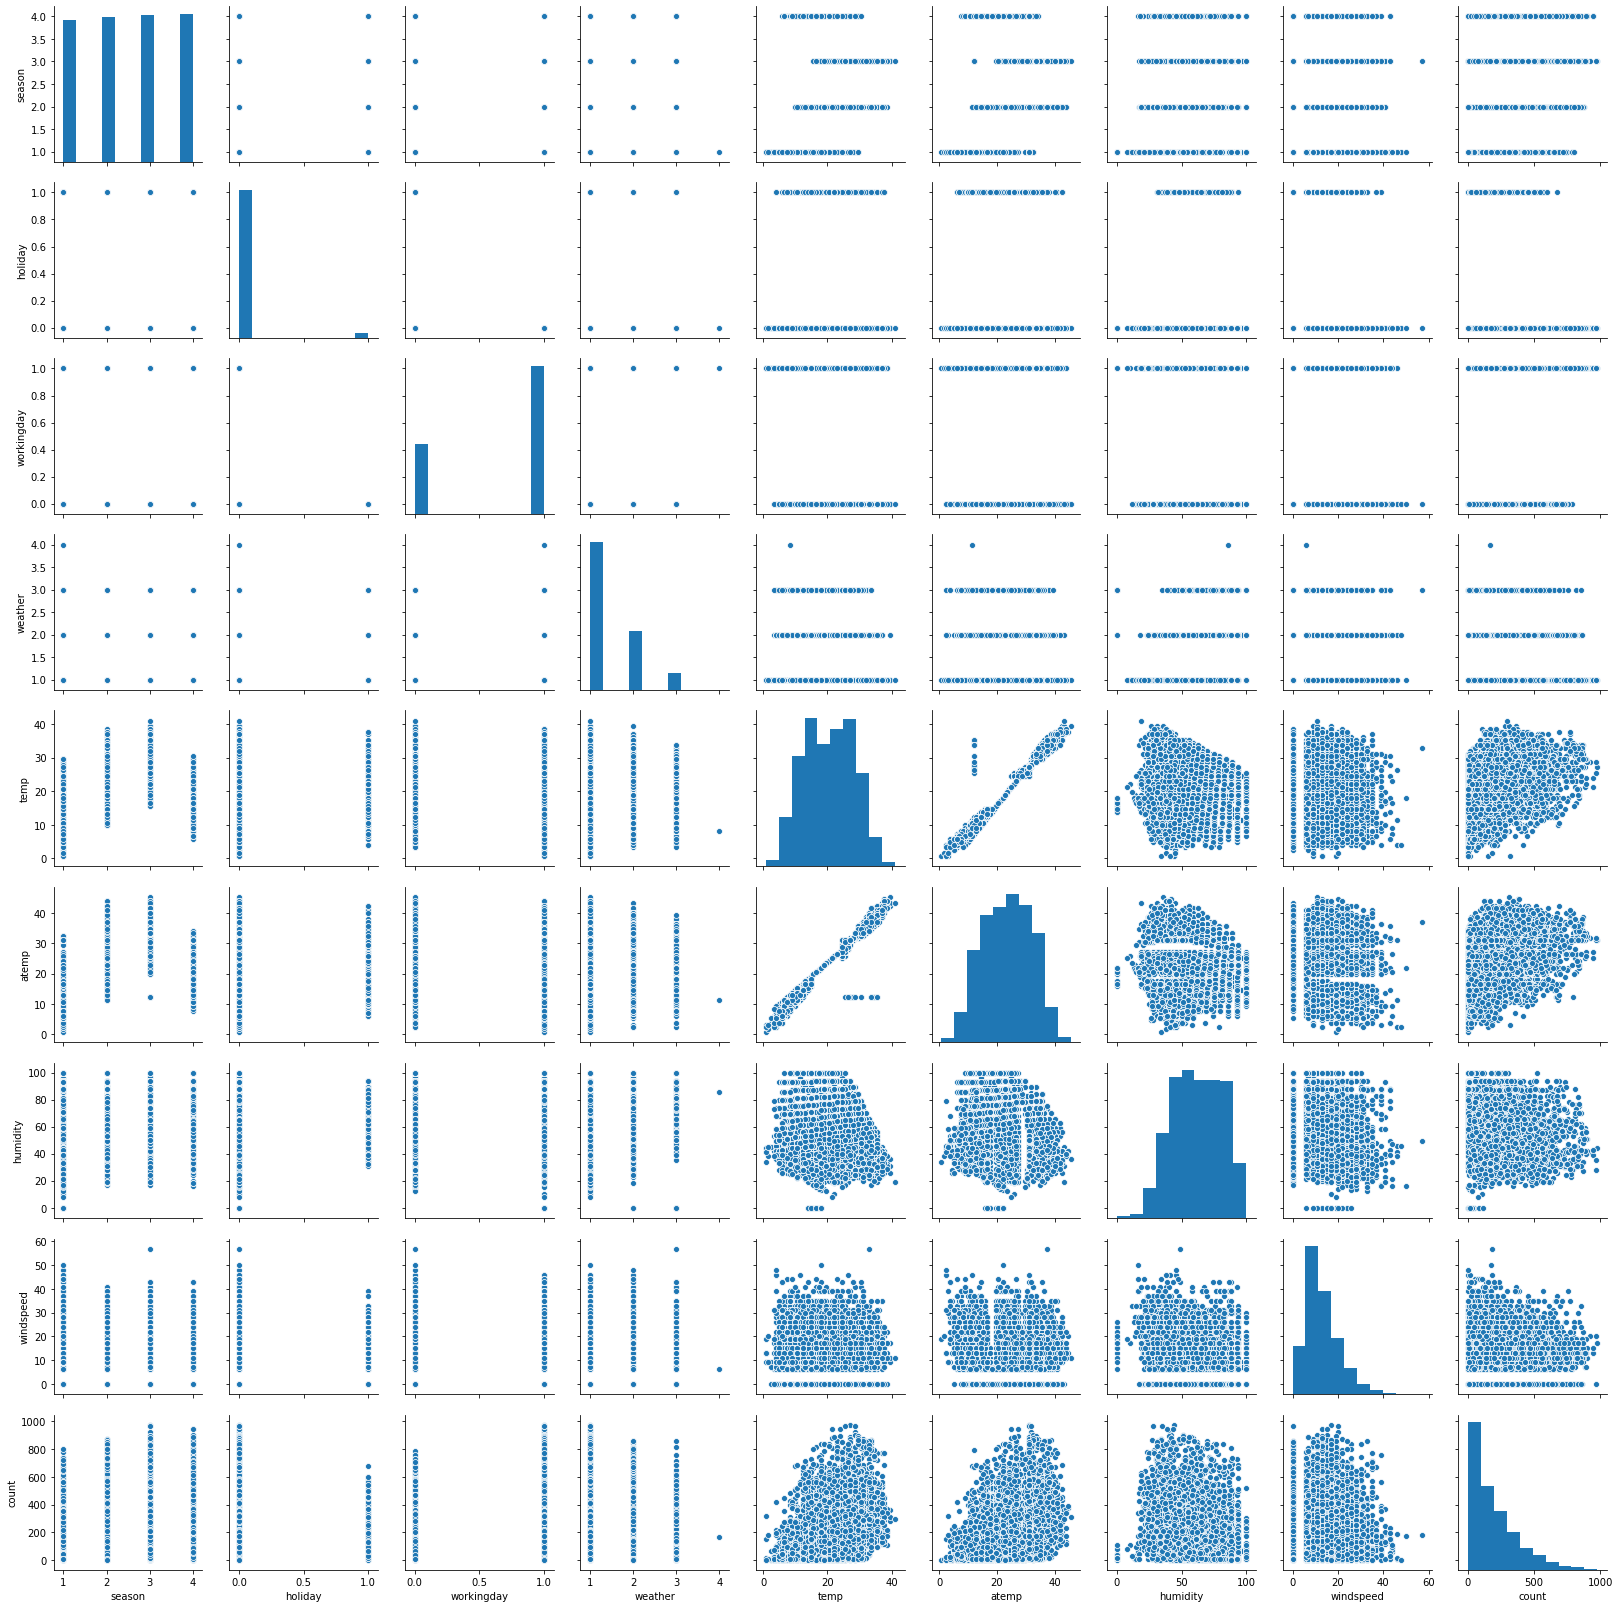

In [45]:
# Plot variables against each other
df_train = X_train.join(y_train)
sns.pairplot(df_train)

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8164 entries, 9792 to 1289
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    8164 non-null   object 
 1   season      8164 non-null   int64  
 2   holiday     8164 non-null   int64  
 3   workingday  8164 non-null   int64  
 4   weather     8164 non-null   int64  
 5   temp        8164 non-null   float64
 6   atemp       8164 non-null   float64
 7   humidity    8164 non-null   int64  
 8   windspeed   8164 non-null   float64
 9   count       8164 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 1021.6+ KB


## 5) Feature Engineering

Will be based on your EDA.

Here we decide on which features to include (at least initially), we will transform features, combine them or plainly pass them through (leave them unchanged).

Disclaimer: This is not an exhaustive feature engineering pipeline. There is more that can be done.

In [54]:
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, \
                                  FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [48]:
# As an example we might want to extract the hour
pd.to_datetime(X_train['datetime']).dt.hour

9792     9
3815    23
2420    18
4176     1
4283    12
        ..
9372    21
7291     4
1344    21
7293     6
1289    14
Name: datetime, Length: 8164, dtype: int64

In [49]:
# Extract the hour of the day from the datetime
def create_hour(df):
    '''
    Creates an hour column from the datetime column
    
    Params:
    -------
    
    df: The DataFrame to be transformed
    '''
    df = df.copy()
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    return df

In [52]:
dummy_features = ['hour']
interaction_features = ['weather', 'workingday']
passthrough_features = ['atemp', 'windspeed', 'humidity', 'holiday', 'season']
column_transformer = ColumnTransformer(transformers=[
                        ('dummy', OneHotEncoder(), dummy_features),
                        ('interaction_polynomial', 
                         PolynomialFeatures(interaction_only=True), interaction_features),
                        ('pass', 'passthrough', passthrough_features)
])

In [55]:
transformer_pipeline = Pipeline(steps=[
                        ('create_hour', FunctionTransformer(create_hour)),
                        ('column_transformer', column_transformer)
])

In [56]:
transformer_pipeline.fit_transform(X_train)

array([[ 0.,  0.,  0., ..., 39.,  0.,  4.],
       [ 0.,  0.,  0., ..., 94.,  0.,  3.],
       [ 0.,  0.,  0., ..., 37.,  0.,  2.],
       ...,
       [ 0.,  0.,  0., ..., 53.,  0.,  2.],
       [ 0.,  0.,  0., ..., 88.,  0.,  2.],
       [ 0.,  0.,  0., ..., 39.,  0.,  1.]])

## 6) Fit a model

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
# Option 1 - standalone
m = LinearRegression()
X_train_transformed = transformer_pipeline.fit_transform(X_train)
m.fit(X_train_transformed, y_train)

LinearRegression()

In [61]:
m.score(X_train_transformed, y_train)

0.6262019380357065

In [62]:
# Option 2 - pipeline
linear_regression = Pipeline(steps=[
                        ('transformer', transformer_pipeline),
                        ('regression', LinearRegression())
])

In [63]:
linear_regression.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('create_hour',
                                  FunctionTransformer(func=<function create_hour at 0x1a2d31b620>)),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('dummy',
                                                                   OneHotEncoder(),
                                                                   ['hour']),
                                                                  ('interaction_polynomial',
                                                                   PolynomialFeatures(interaction_only=True),
                                                                   ['weather',
                                                                    'workingday']),
                                                                  ('pass',
                                                                   'passthrough',
 

In [64]:
linear_regression.score(X_train, y_train)

0.6262019380357065

## 7) Cross-validate / GridSearch

If we just wanted to check, whether our model seems to be overfitting, we could use the plain cross validation.

In [65]:
from sklearn.model_selection import cross_val_score

In [67]:
cross_val_score(m, X_train_transformed, y_train)
# It returns the score for each iteration of the cross validation.
# What the score means, depends on the estimator/model that you pass
# into the cross_val_score

# m is a LinearRegression. It is a regression
# If we run m.score(X_test, y_test) which metric does sklearn return?
# In the case of LinearRegression, the m.score() returns the R^2
# R^2: How much of the variance of y can be explained by our model?
# In the case of our model, it seems to be able to explain around
# 62% of the variance of y
# The perfect model would be 1

# If m was a classifier, m.score() would return the accuracy

array([0.62712436, 0.64635126, 0.60581509, 0.61015541, 0.62791129])

GridSearch helps you to optimize Hyperparameters of a model. Hyperparameters are parameters that are not learned by the model itself, but chosen by whoever builds the model.

E.g. hyperparameters for Random Forest:
- max_depth (how many decision nodes does each tree have)
- estimator_n (how many trees does the forest have)

In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV

In [75]:
param_grid = {
    'regression': [LinearRegression(), RidgeCV()]
}

grid_search = GridSearchCV(linear_regression, param_grid)

In [76]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('create_hour',
                                                         FunctionTransformer(func=<function create_hour at 0x1a2d31b620>)),
                                                        ('column_transformer',
                                                         ColumnTransformer(transformers=[('dummy',
                                                                                          OneHotEncoder(),
                                                                                          ['hour']),
                                                                                         ('interaction_polynomial',
                                                                                          PolynomialFeatures(interaction_only=True),
                                                                                          ['weather',
            

In [78]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.072527,0.030730,0.025758,0.009723,LinearRegression(),{'regression': LinearRegression()},0.627124,0.646351,0.605815,0.610155,0.627911,0.623471,0.014461,2
1,0.072310,0.014937,0.027982,0.006176,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","{'regression': RidgeCV(alphas=array([ 0.1, 1....",0.627253,0.646180,0.605978,0.610210,0.627806,0.623485,0.014357,1


## 8) Testing your model on the test data

In [79]:
linear_regression.score(X_test, y_test)

0.6192049345976073